In [1]:
from verification.generate_plots import generate_2d, generate_2a, create_balanced_dataset, generate_data_proportion_chart, percentage_dif
from verification.verify_seq import *
from verification.subset import analyze_embeddings, save_top_stories, merge_top_stories, determine_bin, make_large_subset, make_proportional_subset_using_other_subset
from src.embedding import SequentialityEmbeddingModel
import pandas as pd
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import torch
import gc
import os

/Users/aidangoeschel/Documents/UCI/CCNL/SemanticAnalysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/aidangoeschel/Documents/UCI/CCNL/SemanticAnalysis/.venv/lib/python3.12/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


mps is used.


In [29]:
# load data
from typing import defaultdict
path = "./datasets/osfstorage-archive/participants/"

data = defaultdict(list) # participant: [stories]

for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    for file in os.listdir(folder_path):
        if file.endswith(".txt"):
            with open(os.path.join(folder_path, file), "r", encoding="windows-1252", errors="ignore") as f:
                stories = f.read().split("\n\n")
                data[folder].append(stories)
            print(f"Loaded {file}")


Loaded P109_pieman.txt
Loaded P109_eyespy.txt
Loaded P136_oregontrail.txt
Loaded P136_baseball.txt
Loaded P131_oregontrail.txt
Loaded P131_baseball.txt
Loaded P138_oregontrail.txt
Loaded P138_baseball.txt
Loaded P107_eyespy.txt
Loaded P107_pieman.txt
Loaded P100_pieman.txt
Loaded P100_eyespy.txt
Loaded P154_baseball.txt
Loaded P154_oregontrail.txt
Loaded P4_pieman.txt
Loaded P4_eyespy.txt
Loaded P153_baseball.txt
Loaded P153_oregontrail.txt
Loaded P3_eyespy.txt
Loaded P3_pieman.txt
Loaded P198_oregontrail.txt
Loaded P198_baseball.txt
Loaded P191_baseball.txt
Loaded P191_oregontrail.txt
Loaded P165_baseball.txt
Loaded P165_oregontrail.txt
Loaded P162_baseball.txt
Loaded P162_oregontrail.txt
Loaded P196_baseball.txt
Loaded P196_oregontrail.txt
Loaded P101_eyespy.txt
Loaded P101_pieman.txt
Loaded P139_oregontrail.txt
Loaded P139_baseball.txt
Loaded P106_pieman.txt
Loaded P106_eyespy.txt
Loaded P130_oregontrail.txt
Loaded P130_baseball.txt
Loaded P108_eyespy.txt
Loaded P108_pieman.txt
Load

## LLM Sequentiality Model

In [36]:
from src.sequentiality import SequentialityModel

# load the model
model = SequentialityModel(model_name="SakanaAI/TinySwallow-1.5B-Instruct", 
                           topic="recollection of an audio narrative", 
                           recall_length=9)


KeyboardInterrupt: 

In [19]:
# run data
llm_data = defaultdict(list)
for participant, stories in tqdm(data.items()):
    for story in stories:
        seq = model.calculate_text_sequentiality(story[0])
        llm_data[participant].append(seq)

100%|██████████| 229/229 [2:45:35<00:00, 43.39s/it]  


In [23]:
import pickle

# Save to file
with open("data_cache.pkl", "wb") as f:
    pickle.dump(llm_data, f)

print("✅ Data saved successfully.")

✅ Data saved successfully.


In [21]:
import pickle

# Load from file
with open("data_cache.pkl", "rb") as f:
    llm_data = pickle.load(f)

print("✅ Data loaded successfully.")

✅ Data loaded successfully.


In [6]:
!pip install openpyxl

Python(30811) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl.metadata (2.7 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [11]:
import pandas as pd

# --- File paths ---
file1 = "./datasets/osfstorage-archive/data/survey/demographic_oregontrail_baseball.xlsx"
file2 = "./datasets/osfstorage-archive/data/survey/demographic_pieman_eyespy.xlsx"

# --- Load both DataFrames ---
df1 = pd.read_excel(file1, engine="openpyxl")
df2 = pd.read_excel(file2, engine="openpyxl")

# --- Standardize column names ---
df1.columns = df1.columns.str.lower()
df2.columns = df2.columns.str.lower()

# --- Merge the DataFrames, aligning by column names ---
demographics = pd.concat([df1, df2], ignore_index=True, sort=False)

# --- Optional: inspect result ---
print(f"Merged DataFrame shape: {demographics.shape}")
print("Columns:", demographics.columns.tolist())
demographics.head()


Merged DataFrame shape: (229, 17)
Columns: ['id', 'platform', 'age', 'gender', 'order_oregontrail', 'order_baseball', 'slider_understood', 'slider_engaged', 'slider_difficult', 'text_strategy', 'text_memorable', 'text_shouldknow', 'text_native', 'text_otherlang', 'text_activity', 'order_pieman', 'order_eyespy']


,id,platform,age,gender,order_oregontrail,order_baseball,slider_understood,slider_engaged,slider_difficult,text_strategy,text_memorable,text_shouldknow,text_native,text_otherlang,text_activity,order_pieman,order_eyespy
0,P117,prolific,75,Female,2.0,1.0,5.0,5.0,3.0,I just paid close attention and tried to remem...,When Ellis piped up to announce that she was a...,I liked the second story much better than the ...,YesDELETE THIS TEXT AND TYPE HERE,No other languageDELETE THIS TEXT AND TYPE HERE,just listeningDELETE THIS TEXT AND TYPE HERE,NaN,NaN
1,P118,prolific,37,Female,2.0,1.0,5.0,5.0,1.0,I simplied just paid close attention. During t...,I think the humorous parts of the story were m...,"Nothing else to know, everything went fine.",Yes,No,I was only listening. I did get up to close a ...,NaN,NaN
2,P119,prolific,45,Female,2.0,1.0,5.0,5.0,4.0,I just paid close attention.,I think the most memorable part of the second ...,No,Yes,No,I only listened to the story.,NaN,NaN
3,P120,prolific,64,Female,2.0,1.0,5.0,5.0,4.0,I tried to put the story in an outline form wh...,The third grade teacher was a good storyteller...,I cannot delete the text in my typed answer. D...,Yes. DELETE THIS TEXT AND TYPE HERE,No I do not. DELETE THIS TEXT AND TYPE HERE,I was not doing anything else. DELETE THIS TEX...,NaN,NaN
4,P121,prolific,37,Female,1.0,2.0,4.0,5.0,5.0,I just closed my eyes and gave the stories my ...,I found it very memorable in the teacher's sto...,"No, nothing else.",yes,no,"Nothing, just sitting with my eyes closed.",NaN,NaN


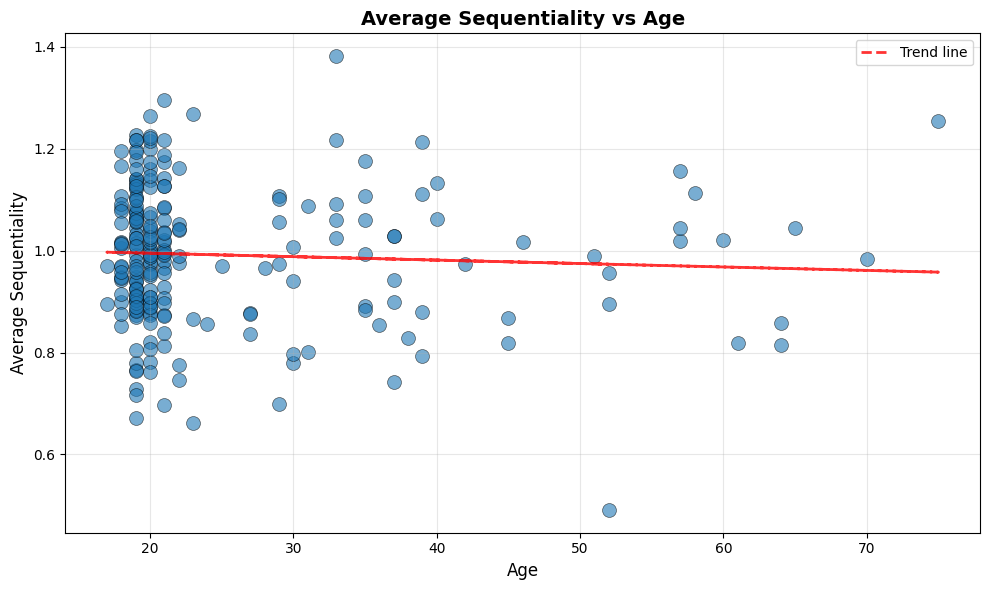

Number of participants: 229

Correlation between Age and Sequentiality: -0.056

Age range: 17 - 75
Sequentiality range: 0.491 - 1.382


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get the set of participant IDs from demographics
demographic_ids = set(demographics['id'].values)

# Calculate average sequentiality only for participants in demographics
avg_sequentiality = {}

for participant_id, trials in llm_data.items():
    # Only process if participant is in demographics
    if participant_id in demographic_ids:
        # Extract only the sequentiality value (first element) from each trial
        seq_values = [trial[0] for trial in trials]
        
        # Calculate average
        avg_sequentiality[participant_id] = np.mean(seq_values)

# Create a dataframe from the averages
seq_df = pd.DataFrame(list(avg_sequentiality.items()), 
                      columns=['id', 'avg_sequentiality'])

# Merge with demographics to get age
merged_df = seq_df.merge(demographics[['id', 'age']], on='id', how='left')

# Remove any rows with missing age data
merged_df = merged_df.dropna(subset=['age'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['age'], merged_df['avg_sequentiality'], 
           alpha=0.6, s=100, edgecolors='black', linewidth=0.5)

plt.xlabel('Age', fontsize=12)
plt.ylabel('Average Sequentiality', fontsize=12)
plt.title('Average Sequentiality vs Age', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add a trend line
z = np.polyfit(merged_df['age'], merged_df['avg_sequentiality'], 1)
p = np.poly1d(z)
plt.plot(merged_df['age'], p(merged_df['age']), 
        "r--", alpha=0.8, linewidth=2, label=f'Trend line')

plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Number of participants: {len(merged_df)}")
print(f"\nCorrelation between Age and Sequentiality: {merged_df['age'].corr(merged_df['avg_sequentiality']):.3f}")
print(f"\nAge range: {merged_df['age'].min():.0f} - {merged_df['age'].max():.0f}")
print(f"Sequentiality range: {merged_df['avg_sequentiality'].min():.3f} - {merged_df['avg_sequentiality'].max():.3f}")

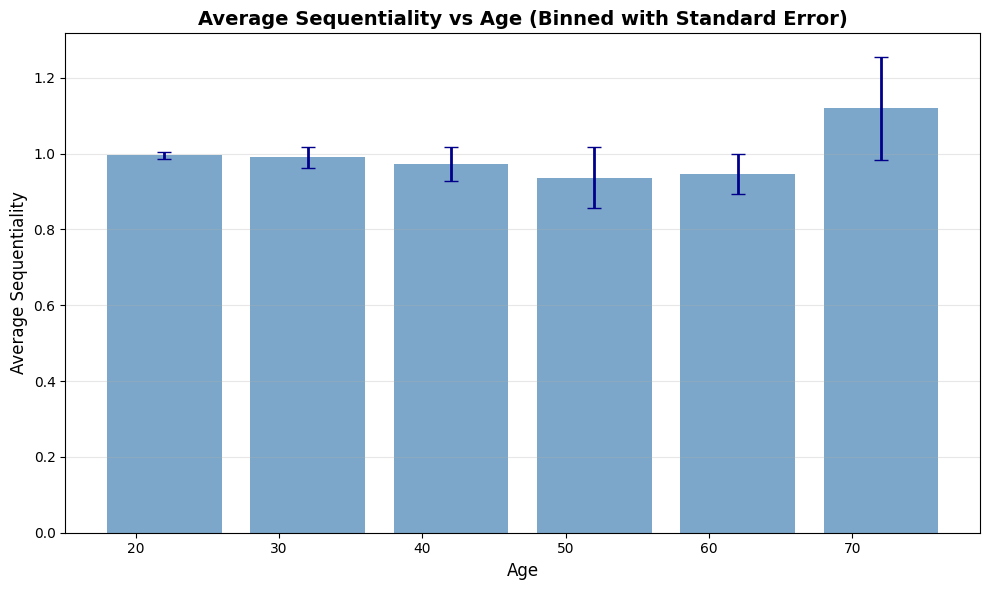

Number of participants: 229
Number of age bins: 6

Bin statistics:
                    mean        se  count
age_bin                                  
(16.999, 27.0]  0.995412  0.009800    174
(27.0, 37.0]    0.989752  0.027976     29
(37.0, 47.0]    0.972509  0.043688     11
(47.0, 57.0]    0.935975  0.080195      7
(57.0, 67.0]    0.945161  0.052911      6
(67.0, 77.0]    1.119324  0.135117      2

Correlation between Age and Sequentiality: -0.056


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Get the set of participant IDs from demographics
demographic_ids = set(demographics['id'].values)

# Calculate average sequentiality only for participants in demographics
avg_sequentiality = {}

for participant_id, trials in llm_data.items():
    # Only process if participant is in demographics
    if participant_id in demographic_ids:
        # Extract only the sequentiality value (first element) from each trial
        seq_values = [trial[0] for trial in trials]
        
        # Calculate average
        avg_sequentiality[participant_id] = np.mean(seq_values)

# Create a dataframe from the averages
seq_df = pd.DataFrame(list(avg_sequentiality.items()), 
                      columns=['id', 'avg_sequentiality'])

# Merge with demographics to get age
merged_df = seq_df.merge(demographics[['id', 'age']], on='id', how='left')

# Remove any rows with missing age data
merged_df = merged_df.dropna(subset=['age'])

# Create age bins (adjust bin size as needed)
bin_size = 10  # 5-year bins
min_age = int(merged_df['age'].min())
max_age = int(merged_df['age'].max())
bins = range(min_age, max_age + bin_size, bin_size)

# Assign each participant to a bin
merged_df['age_bin'] = pd.cut(merged_df['age'], bins=bins, include_lowest=True)

# Calculate mean and standard error for each bin
binned_stats = merged_df.groupby('age_bin', observed=True)['avg_sequentiality'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('count', 'count')
])

# Calculate standard error (std / sqrt(n))
binned_stats['se'] = binned_stats['std'] / np.sqrt(binned_stats['count'])

# Get bin centers for plotting
binned_stats['age_center'] = [interval.mid for interval in binned_stats.index]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot with error bars as bar graph
plt.bar(binned_stats['age_center'], binned_stats['mean'], 
        width=bin_size*0.8, yerr=binned_stats['se'],
        color='steelblue', alpha=0.7, 
        capsize=5, error_kw={'linewidth': 2, 'ecolor': 'darkblue'})

plt.xlabel('Age', fontsize=12)
plt.ylabel('Average Sequentiality', fontsize=12)
plt.title('Average Sequentiality vs Age (Binned with Standard Error)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Number of participants: {len(merged_df)}")
print(f"Number of age bins: {len(binned_stats)}")
print(f"\nBin statistics:")
print(binned_stats[['mean', 'se', 'count']].to_string())
print(f"\nCorrelation between Age and Sequentiality: {merged_df['age'].corr(merged_df['avg_sequentiality']):.3f}")

## Embedding Model

In [27]:
from src.embedding import SequentialityEmbeddingModel

# load the model
embed = hub.load(
"https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2"
)
model = SequentialityEmbeddingModel(embed,
                        topic="recollection of an audio narrative", 
                        recall_length=9)

In [30]:
# run data
embedd_data = defaultdict(list)
for participant, stories in tqdm(data.items()):
    for story in stories:
        seq = model.calculate_text_sequentiality(story[0])
        embedd_data[participant].append(seq)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 229/229 [00:41<00:00,  5.54it/s]


In [19]:
import pandas as pd

# --- File paths (update these with your actual file names) ---
file1 = "./datasets/osfstorage-archive/data/survey/demographic_oregontrail_baseball.xlsx"
file2 = "./datasets/osfstorage-archive/data/survey/demographic_pieman_eyespy.xlsx"

# --- Load the Excel sheets into DataFrames ---
df1 = pd.read_excel(file1)
df2 = pd.read_excel(file2)

# --- Merge the DataFrames ---
demographics = pd.concat([df1, df2], ignore_index=True)

# --- Optional: verify result ---
print(f"Merged DataFrame shape: {demographics.shape}")
print(demographics.columns)


Merged DataFrame shape: (229, 19)
Index(['ID', 'platform', 'Age', 'Gender', 'order_oregontrail',
       'order_baseball', 'Slider_understood', 'Slider_engaged',
       'Slider_difficult', 'Text_strategy', 'Text_memorable',
       'Text_shouldknow', 'Text_native', 'Text_otherlang', 'Text_activity',
       'age', 'gender', 'order_pieman', 'order_eyespy'],
      dtype='object')


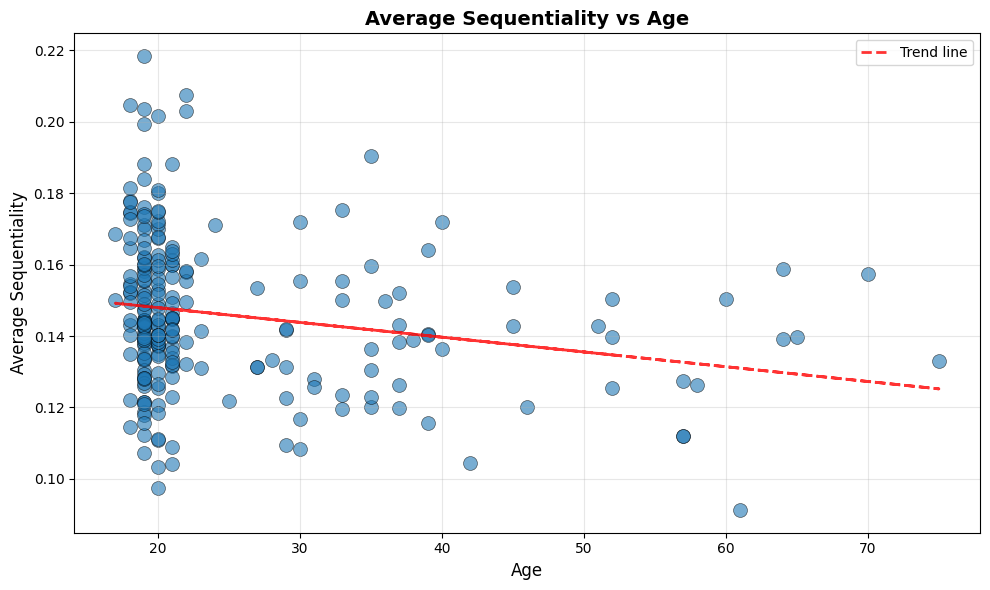

Number of participants: 229

Correlation between Age and Sequentiality: -0.214

Age range: 17 - 75
Sequentiality range: 0.091 - 0.218


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Get the set of participant IDs from demographics
demographic_ids = set(demographics['id'].values)

# Calculate average sequentiality only for participants in demographics
avg_sequentiality = {}

for participant_id, trials in embedd_data.items():
    # Only process if participant is in demographics
    if participant_id in demographic_ids:
        # Extract only the sequentiality value (first element) from each trial
        seq_values = [trial[0] for trial in trials]
        
        # Calculate average
        avg_sequentiality[participant_id] = np.mean(seq_values)

# Create a dataframe from the averages
seq_df = pd.DataFrame(list(avg_sequentiality.items()), 
                      columns=['id', 'avg_sequentiality'])

# Merge with demographics to get age
merged_df = seq_df.merge(demographics[['id', 'age']], on='id', how='left')

# Remove any rows with missing age data
merged_df = merged_df.dropna(subset=['age'])

# Create the plot
plt.figure(figsize=(10, 6))
plt.scatter(merged_df['age'], merged_df['avg_sequentiality'], 
           alpha=0.6, s=100, edgecolors='black', linewidth=0.5)

plt.xlabel('Age', fontsize=12)
plt.ylabel('Average Sequentiality', fontsize=12)
plt.title('Average Sequentiality vs Age', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add a trend line
z = np.polyfit(merged_df['age'], merged_df['avg_sequentiality'], 1)
p = np.poly1d(z)
plt.plot(merged_df['age'], p(merged_df['age']), 
        "r--", alpha=0.8, linewidth=2, label=f'Trend line')

plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Number of participants: {len(merged_df)}")
print(f"\nCorrelation between Age and Sequentiality: {merged_df['age'].corr(merged_df['avg_sequentiality']):.3f}")
print(f"\nAge range: {merged_df['age'].min():.0f} - {merged_df['age'].max():.0f}")
print(f"Sequentiality range: {merged_df['avg_sequentiality'].min():.3f} - {merged_df['avg_sequentiality'].max():.3f}")

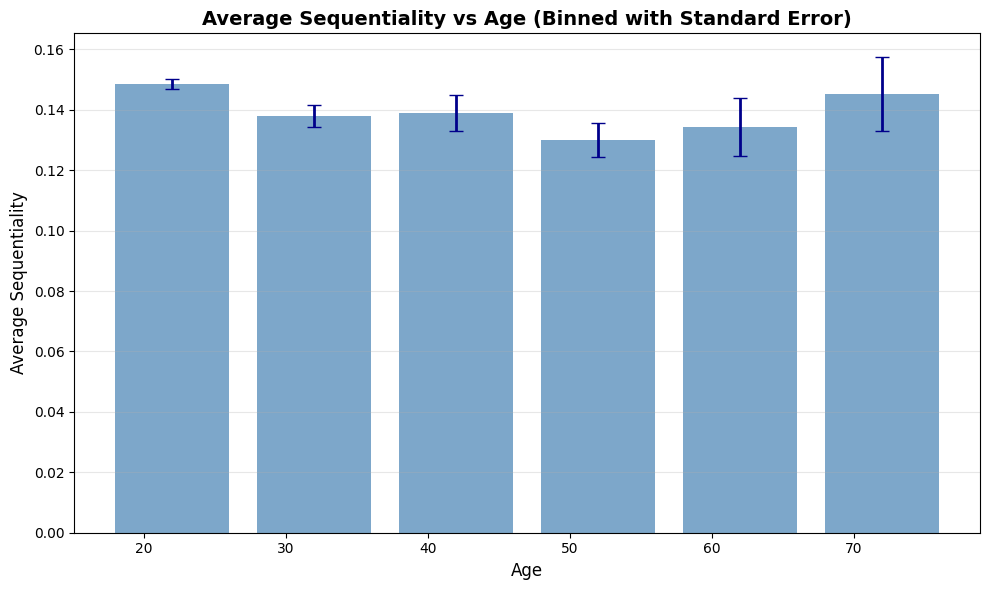

Number of participants: 229
Number of age bins: 6

Bin statistics:
                    mean        se  count
age_bin                                  
(16.999, 27.0]  0.148641  0.001645    174
(27.0, 37.0]    0.137926  0.003718     29
(37.0, 47.0]    0.138989  0.006063     11
(47.0, 57.0]    0.129996  0.005663      7
(57.0, 67.0]    0.134276  0.009714      6
(67.0, 77.0]    0.145215  0.012243      2

Correlation between Age and Sequentiality: -0.214


In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Get the set of participant IDs from demographics
demographic_ids = set(demographics['id'].values)

# Calculate average sequentiality only for participants in demographics
avg_sequentiality = {}

for participant_id, trials in embedd_data.items():
    # Only process if participant is in demographics
    if participant_id in demographic_ids:
        # Extract only the sequentiality value (first element) from each trial
        seq_values = [trial[0] for trial in trials]
        
        # Calculate average
        avg_sequentiality[participant_id] = np.mean(seq_values)

# Create a dataframe from the averages
seq_df = pd.DataFrame(list(avg_sequentiality.items()), 
                      columns=['id', 'avg_sequentiality'])

# Merge with demographics to get age
merged_df = seq_df.merge(demographics[['id', 'age']], on='id', how='left')

# Remove any rows with missing age data
merged_df = merged_df.dropna(subset=['age'])

# Create age bins (adjust bin size as needed)
bin_size = 10  # 5-year bins
min_age = int(merged_df['age'].min())
max_age = int(merged_df['age'].max())
bins = range(min_age, max_age + bin_size, bin_size)

# Assign each participant to a bin
merged_df['age_bin'] = pd.cut(merged_df['age'], bins=bins, include_lowest=True)

# Calculate mean and standard error for each bin
binned_stats = merged_df.groupby('age_bin', observed=True)['avg_sequentiality'].agg([
    ('mean', 'mean'),
    ('std', 'std'),
    ('count', 'count')
])

# Calculate standard error (std / sqrt(n))
binned_stats['se'] = binned_stats['std'] / np.sqrt(binned_stats['count'])

# Get bin centers for plotting
binned_stats['age_center'] = [interval.mid for interval in binned_stats.index]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot with error bars as bar graph
plt.bar(binned_stats['age_center'], binned_stats['mean'], 
        width=bin_size*0.8, yerr=binned_stats['se'],
        color='steelblue', alpha=0.7, 
        capsize=5, error_kw={'linewidth': 2, 'ecolor': 'darkblue'})

plt.xlabel('Age', fontsize=12)
plt.ylabel('Average Sequentiality', fontsize=12)
plt.title('Average Sequentiality vs Age (Binned with Standard Error)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Number of participants: {len(merged_df)}")
print(f"Number of age bins: {len(binned_stats)}")
print(f"\nBin statistics:")
print(binned_stats[['mean', 'se', 'count']].to_string())
print(f"\nCorrelation between Age and Sequentiality: {merged_df['age'].corr(merged_df['avg_sequentiality']):.3f}")

In [5]:
with open("./datasets/osfstorage-archive/experiment_materials/stimuli/baseball_transcript.txt", "r", encoding="windows-1252", errors="ignore") as f:
    baseball = f.read()

with open("./datasets/osfstorage-archive/experiment_materials/stimuli/oregontrail_transcript.txt", "r", encoding="windows-1252", errors="ignore") as f:
    oregon_trail = f.read() 

with open("./datasets/osfstorage-archive/experiment_materials/stimuli/pieman_transcript.txt", "r", encoding="windows-1252", errors="ignore") as f:
    pieman = f.read()

with open("./datasets/osfstorage-archive/experiment_materials/stimuli/eyespy_transcript.txt", "r", encoding="windows-1252", errors="ignore") as f:
    eyespy = f.read()

stories = [baseball, oregon_trail, pieman, eyespy]

In [18]:
from src.sequentiality import SequentialityModel

# load the model
model = SequentialityModel(model_name="SakanaAI/TinySwallow-1.5B-Instruct", 
                           topic="a short story", 
                           recall_length=9)

In [13]:
from src.embedding import SequentialityEmbeddingModel

# load the model
embed = hub.load(
"https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2"
)
model = SequentialityEmbeddingModel(embed,
                        topic="recollection of an audio narrative", 
                        recall_length=9)

In [19]:
seqs = []

for story in stories:
    seq = model.calculate_text_sequentiality(story)
    print(f"Sequentiality: {seq[0]:.3f}")

    seqs.append(seq[0])

Sequentiality: 1.335
Sequentiality: 1.067
Sequentiality: 1.100
Sequentiality: 1.171


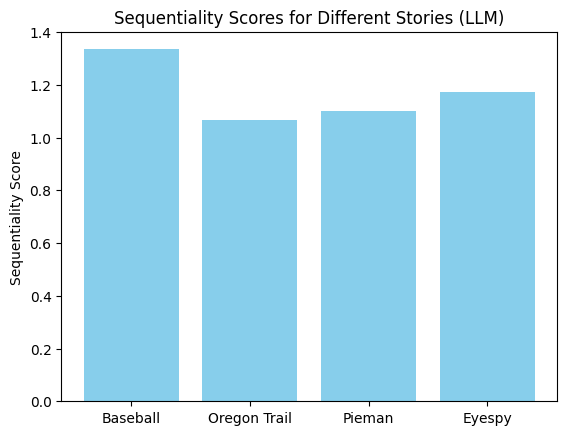

In [20]:
import matplotlib.pyplot as plt

plt.bar(['Baseball', 'Oregon Trail', 'Pieman', 'Eyespy'], seqs, color='skyblue')
plt.ylabel('Sequentiality Score')
plt.title('Sequentiality Scores for Different Stories (LLM)')
plt.show()

Analysis DataFrame shape: (458, 5)

First few rows:
  participant_id         story  sequentiality  \
0           P117      baseball       0.111276   
1           P117  oregon_trail       0.091145   
2           P118      baseball       0.111276   
3           P118  oregon_trail       0.091145   
4           P119      baseball       0.111276   

                                  memorable_response  difficulty  
0  When Ellis piped up to announce that she was a...         3.0  
1  When Ellis piped up to announce that she was a...         3.0  
2  I think the humorous parts of the story were m...         1.0  
3  I think the humorous parts of the story were m...         1.0  
4  I think the most memorable part of the second ...         4.0  

ANALYSIS 1: Sequentiality vs Memorability

Story Summary (sorted by sequentiality):
              sequentiality  memorable_response
story                                          
oregon_trail       0.091145                 112
pieman             0.1

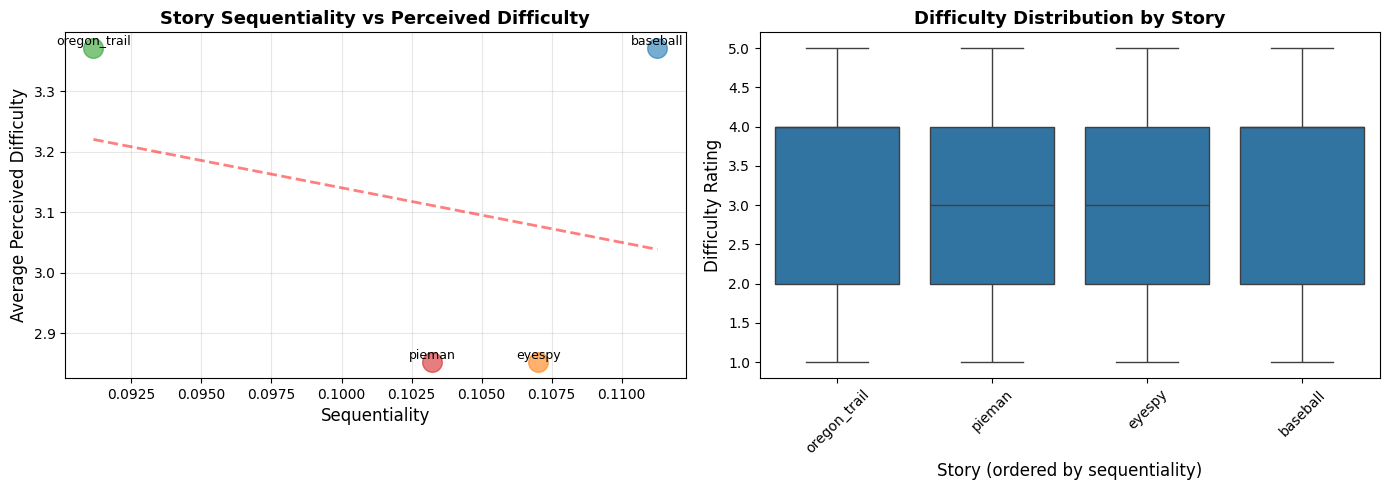


ANOVA: Does difficulty differ significantly across stories?
F-statistic = 6.310, p-value = 0.000


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

# Assuming you have:
# df = your dataframe
# sequentiality = [baseball_seq, oregon_trail_seq, pieman_seq, eyespy_seq]

# Create a mapping of stories to their sequentiality values
story_sequentiality = {
    'baseball': seqs[0],
    'oregon_trail': seqs[1],
    'pieman': seqs[2],
    'eyespy': seqs[3]
}

# Reshape data from wide to long format for analysis
# Each participant will have multiple rows (one per story they rated)
analysis_data = []

for idx, row in demographics.iterrows():
    participant_id = row['id']
    
    # For each story, create a row with sequentiality and ratings
    stories_info = [
        ('baseball', row['order_baseball'], 'text_memorable'),
        ('oregon_trail', row['order_oregontrail'], 'text_memorable'),
        ('pieman', row['order_pieman'], 'text_memorable'),
        ('eyespy', row['order_eyespy'], 'text_memorable')
    ]
    
    for story, order, memorable_col in stories_info:
        # Check if they saw this story (order is not null)
        if pd.notna(order):
            analysis_data.append({
                'participant_id': participant_id,
                'story': story,
                'sequentiality': story_sequentiality[story],
                'memorable_response': row[memorable_col],
                'difficulty': row['slider_difficult']
            })

# Create analysis dataframe
analysis_df = pd.DataFrame(analysis_data)

print("Analysis DataFrame shape:", analysis_df.shape)
print("\nFirst few rows:")
print(analysis_df.head())

# --- Analysis 1: Sequentiality vs Memorability ---
print("\n" + "="*60)
print("ANALYSIS 1: Sequentiality vs Memorability")
print("="*60)

# Calculate correlation
# Note: You'll need to code/quantify the memorable_response if it's text
# For now, let's assume you'll process text_memorable somehow

# Group by story to see average patterns
story_summary = analysis_df.groupby('story').agg({
    'sequentiality': 'first',
    'memorable_response': 'count'  # count of responses
}).sort_values('sequentiality')

print("\nStory Summary (sorted by sequentiality):")
print(story_summary)

# --- Analysis 2: Sequentiality vs Difficulty ---
print("\n" + "="*60)
print("ANALYSIS 2: Sequentiality vs Difficulty")
print("="*60)

difficulty_by_story = analysis_df.groupby('story').agg({
    'sequentiality': 'first',
    'difficulty': ['mean', 'std', 'count']
}).round(2)

print("\nDifficulty by Story (sorted by sequentiality):")
difficulty_by_story = difficulty_by_story.sort_values(('sequentiality', 'first'))
print(difficulty_by_story)

# Calculate correlation between sequentiality and difficulty
story_avg_difficulty = analysis_df.groupby('story').agg({
    'sequentiality': 'first',
    'difficulty': 'mean'
}).reset_index()

correlation = stats.pearsonr(story_avg_difficulty['sequentiality'], 
                             story_avg_difficulty['difficulty'])
print(f"\nCorrelation between sequentiality and perceived difficulty:")
print(f"r = {correlation[0]:.3f}, p = {correlation[1]:.3f}")

# --- Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Sequentiality vs Difficulty
ax1 = axes[0]
for story in story_avg_difficulty['story']:
    story_data = story_avg_difficulty[story_avg_difficulty['story'] == story]
    ax1.scatter(story_data['sequentiality'], story_data['difficulty'], 
               s=200, alpha=0.6, label=story)
    ax1.text(story_data['sequentiality'].values[0], 
            story_data['difficulty'].values[0], 
            story, fontsize=9, ha='center', va='bottom')

# Add trend line
z = np.polyfit(story_avg_difficulty['sequentiality'], 
               story_avg_difficulty['difficulty'], 1)
p = np.poly1d(z)
x_line = np.linspace(story_avg_difficulty['sequentiality'].min(), 
                     story_avg_difficulty['sequentiality'].max(), 100)
ax1.plot(x_line, p(x_line), "r--", alpha=0.5, linewidth=2)

ax1.set_xlabel('Sequentiality', fontsize=12)
ax1.set_ylabel('Average Perceived Difficulty', fontsize=12)
ax1.set_title('Story Sequentiality vs Perceived Difficulty', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Distribution of difficulty ratings by story
ax2 = axes[1]
story_order = story_avg_difficulty.sort_values('sequentiality')['story'].tolist()
analysis_df['story'] = pd.Categorical(analysis_df['story'], categories=story_order, ordered=True)
sns.boxplot(data=analysis_df, x='story', y='difficulty', ax=ax2, order=story_order)
ax2.set_xlabel('Story (ordered by sequentiality)', fontsize=12)
ax2.set_ylabel('Difficulty Rating', fontsize=12)
ax2.set_title('Difficulty Distribution by Story', fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Additional statistical test: ANOVA
print("\n" + "="*60)
print("ANOVA: Does difficulty differ significantly across stories?")
print("="*60)
groups = [analysis_df[analysis_df['story'] == story]['difficulty'].dropna() 
          for story in analysis_df['story'].unique()]
f_stat, p_value = stats.f_oneway(*groups)
print(f"F-statistic = {f_stat:.3f}, p-value = {p_value:.3f}")

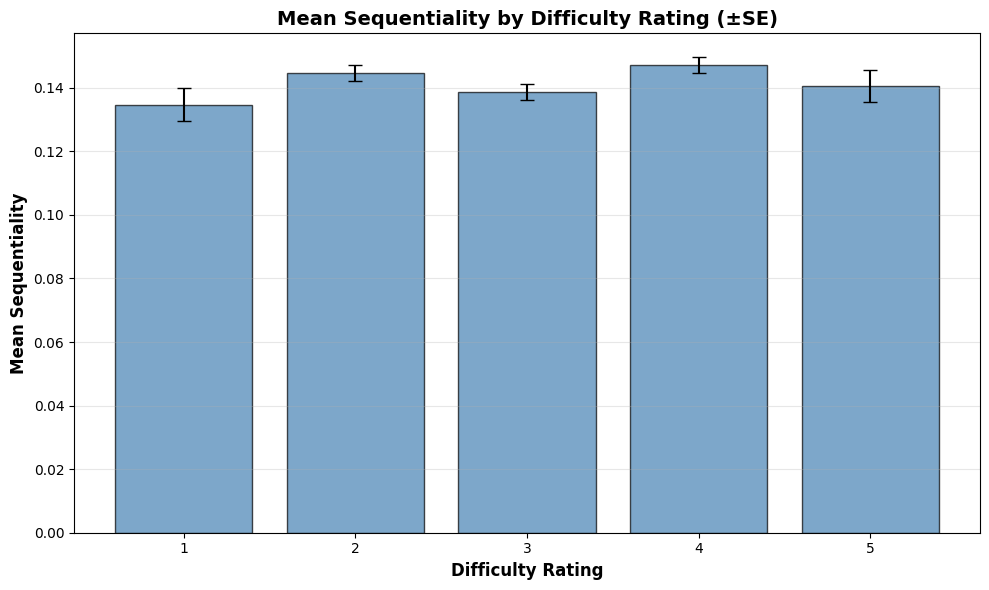

Sample sizes per bin:
  difficulty_bin  count
0              1     20
1              2     92
2              3     64
3              4    146
4              5     26


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have:
# df = your dataframe
# llm_data = {"P1": [[sequentiality, [list1], [list2]], [sequentiality, [list1], [list2]]]}

plot_data = embedd_data
# plot_data = llm_data

def get_story_order_for_participant(df, participant_id):
    """Get the order in which stories were presented to a participant"""
    row = df[df['id'] == participant_id].iloc[0]
    
    stories = [
        ('baseball', row['order_baseball']),
        ('oregon_trail', row['order_oregontrail']),
        ('pieman', row['order_pieman']),
        ('eyespy', row['order_eyespy'])
    ]
    
    stories = [(name, order) for name, order in stories if pd.notna(order)]
    stories.sort(key=lambda x: x[1])
    
    return [name for name, _ in stories]

# Build analysis dataframe
analysis_data = []

for participant_id, llm_entries in plot_data.items():
    if participant_id not in demographics['id'].values:
        continue
    
    participant_row = demographics[demographics['id'] == participant_id].iloc[0]
    difficulty = participant_row['slider_difficult']
    story_order = get_story_order_for_participant(demographics, participant_id)
    
    # Each entry is [sequentiality, [list1], [list2]]
    for idx, entry in enumerate(llm_entries):
        sequentiality = entry[0]  # First element is sequentiality
        
        if idx < len(story_order):
            analysis_data.append({
                'participant_id': participant_id,
                'sequentiality': sequentiality,
                'difficulty': difficulty
            })

analysis_df = pd.DataFrame(analysis_data)

# Create difficulty bins (adjust range if your scale differs)
analysis_df['difficulty_bin'] = pd.cut(
    analysis_df['difficulty'], 
    bins=[0, 1, 2, 3, 4, 5],
    labels=['1', '2', '3', '4', '5'],
    include_lowest=True
)

# Calculate means and standard errors
bin_means = analysis_df.groupby('difficulty_bin', observed=True)['sequentiality'].agg(['mean', 'std', 'count']).reset_index()
bin_means['se'] = bin_means['std'] / np.sqrt(bin_means['count'])

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
x_pos = range(len(bin_means))
ax.bar(x_pos, bin_means['mean'], yerr=bin_means['se'], 
       capsize=5, alpha=0.7, color='steelblue', edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels(bin_means['difficulty_bin'])
ax.set_xlabel('Difficulty Rating', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Sequentiality', fontsize=12, fontweight='bold')
ax.set_title('Mean Sequentiality by Difficulty Rating (±SE)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Sample sizes per bin:")
print(bin_means[['difficulty_bin', 'count']])

In [26]:
spoken = [
    ("Last time I went on a trip? I went to Wisconsin. Uh, it was with Emmy, it was for like a job offer in Wisconsin, kinda crazy. And then, yeah, like we saw the Epic campus and everything. Saw my brother, and uh, a lot of flight issues. Like, we missed two flights, out of four, so it was pretty fun.", "A short story about the last time someone went on a trip."),
    ("Last time I went on a trip, I went to England with my family. Oh yeah, we went to several cities in England. We went to London, Westminster, Bath, Redding. Yeah. Went to a bunch of churches.",  "A short story about the last time someone went on a trip."),
    ("Last time I was at a restaurant was with my girlfriend, we went to a Thai place in Fountain Valley. It was awesome, we got hella leftovers for fairly cheap.", "A short story about the last time someone went to a restaurant."),
    ("We went to BCD Tofuhouse in Diamond Jamboree. I went with my boyfriend and their two, or his two roommates. My brother didn’t end up going because he had work, but we went there. I got the combo, which I typically do.", "A short story about the last time someone went to a restaurant."),
    ("I don’t remember the last time I stubbed my toe but it was probably at my apartment coming home late at night and trying to wander around. I probably just jammed my foot into the couch or something", "A short story about the last time someone stubbed their toe."),
    ("The last time I stubbed my toe was probably last weekend. I was just walking around my living room pacing back and forth and trying to practice for my physics midterm just recalling facts and then I walked right into the couch and didn't realize it until after the pain hit.", "A short story about the last time someone stubbed their toe."),
    ("I don’t think this is exactly the last time, but it’s like the only time I can remember. Like I broke, I dropped one of the dishes in my house, which I wouldn’t consider to be like mine I guess, it’s like my parents’? Yeah, I didn’t pay for it.", "A short story about someone breaking something that wasn’t theirs."),
    ("Broke something that wasn’t mine? Uh… My friend's pencil? I actually don’t know", "A short story about someone breaking something that wasn’t theirs.")
]

written = [
    ("I went to a restaurant in Huntington Beach for my girlfriend, Emmy’s, birthday. We went and played mini golf at this place we went for our first date, and then went to this cool rooftop restaurant that overlooks the beach and ocean. It was fairly cheap, especially for the price, which I was stoked about, and I shared the place with some of my friends for a date spot.",  "A short story about the last time someone went to a restaurant."),
    ("Last time I went to a restaurant, I went to the Costco food court with Aidan. I ran into an old teammate at the food court. We each ordered a slice of pizza, I got pepperoni. ",  "A short story about the last time someone went to a restaurant."),
    ("Glacier national park trip with marquesa - we hit 7 states in 9 days and also went through Yellowstone. Incredible views, camping in BLM land the whole way through to keep costs down and the best road trip I’ve ever been on. My favorite part was the sun setting over the mountain “heavens Peak” as we drove back from our hikes on the east side of the park heading west.", "A short story about the last time someone went on a trip."),
    ("The last trip I went on was to Utah with my boyfriend, my brother, and their friends. We went to Zion and did a couple hikes on the drive to the AirBnb as well as while we were there. While there, my boyfriend and I stayed in a frivolous room that smelt of must and had a poor bathroom vent that resulted in my mouthguard becoming a breeding ground for black mold. Overall, I had a fun time, and look forward to travelling again this year. Additionally, I brought back two rocks, one from each hike, and have yet to date them for when we went. The next trip we go on, I’ll be sure to bring home another rock and date that one as well.", "A short story about the last time someone went on a trip."),
    ("The last thing I broke was my roommate’s blender. I wanted to make a smoothie and was reaching to the top cabinet in our kitchen. However, when I climbed up on the ladder I dropped the plastic part of the blender and it shattered on the ground! Luckily, she wasn’t too upset at me", "A short story about someone breaking something that wasn’t theirs."),
    ("It was last week I was rushing on the way to school then I forgot my laptop. I ran back to my room and stubbed my toe on the door way", "A short story about the last time someone stubbed their toe."),
    ("I was around 13 the last time I broke something that wasn't mine. I was throwing around a ball with my brother in the living room when the ball hit a candle holder. We both confessed to our mom when she came back home from work later that evening.", "A short story about someone breaking something that wasn’t theirs."),
    ("While I was showering, I knocked over a shampoo bottle. My eyes were closed at the time, so I didn’t even realize. However, a sudden surge of pain indicated to me that the bottle had fallen from the ledge that it had previously been sitting on onto my left toe.", "A short story about the last time someone stubbed their toe.")
]

In [27]:
from src.sequentiality import SequentialityModel

# load the model
model = SequentialityModel(model_name="SakanaAI/TinySwallow-1.5B-Instruct", 
                           topic="a story ", 
                           recall_length=9)

spoken_seqs = []
for spoken_story, topic in spoken:
    seq = model.calculate_text_sequentiality(spoken_story, topic=topic)
    print(f"Spoken Story Sequentiality: {seq[0]:.3f}")
    spoken_seqs.append(seq[0])

written_seqs = []
for written_story, topic in written:
    seq = model.calculate_text_sequentiality(written_story, topic=topic)
    print(f"Written Story Sequentiality: {seq[0]:.3f}")
    written_seqs.append(seq[0])



Spoken Story Sequentiality: 0.587
Spoken Story Sequentiality: 1.445
Spoken Story Sequentiality: 0.306
Spoken Story Sequentiality: 0.447
Spoken Story Sequentiality: 0.538
Spoken Story Sequentiality: -0.017
Spoken Story Sequentiality: 0.364
Spoken Story Sequentiality: 0.150
Written Story Sequentiality: -0.002
Written Story Sequentiality: 0.205
Written Story Sequentiality: 0.343
Written Story Sequentiality: 0.358
Written Story Sequentiality: 0.275
Written Story Sequentiality: 0.209
Written Story Sequentiality: 0.366
Written Story Sequentiality: 0.323


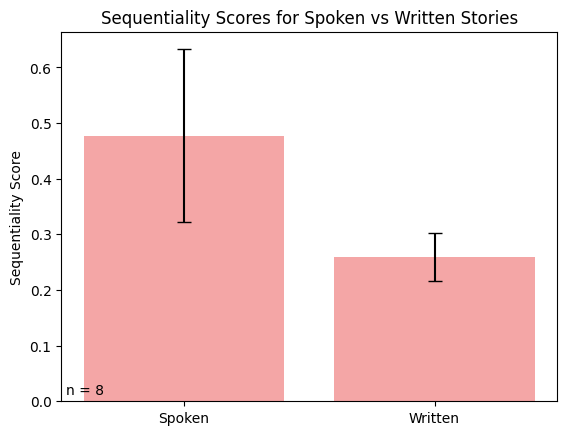

In [28]:
import matplotlib.pyplot as plt
import numpy as np

means = [np.mean(spoken_seqs), np.mean(written_seqs)]
ses = [np.std(spoken_seqs, ddof=1)/np.sqrt(len(spoken_seqs)),
       np.std(written_seqs, ddof=1)/np.sqrt(len(written_seqs))]
labels = ['Spoken', 'Written']
sample_size = len(spoken_seqs)

plt.bar(labels, means, color='lightcoral', alpha=0.7, yerr=ses, capsize=5)
plt.ylabel('Sequentiality Score')
plt.title('Sequentiality Scores for Spoken vs Written Stories')

# Add sample size label in bottom left corner
plt.text(0.01, 0.01, f'n = {sample_size}', 
         transform=plt.gca().transAxes, ha='left', va='bottom', fontsize=10)

plt.show()


In [30]:
tell_me = "Trees are green because their leaves contain chlorophyll, a pigment that absorbs light from the sun to power photosynthesis. Chlorophyll absorbs red and blue wavelengths of light most efficiently, but it reflects green light, which is why leaves appear green to our eyes. During photosynthesis, chlorophyll helps convert sunlight, carbon dioxide, and water into sugars that fuel the tree’s growth. In autumn, when chlorophyll breaks down, the green color fades and other pigments like carotenoids and anthocyanins become visible."
explain = "Trees are green because their leaves contain chlorophyll, a pigment that absorbs sunlight for photosynthesis—the process plants use to make food from light, water, and carbon dioxide. Chlorophyll absorbs red and blue light most efficiently but reflects green light, which is why we see leaves as green. This reflection gives trees their characteristic color, especially during the growing season. In autumn, when chlorophyll breaks down, other pigments become visible, causing leaves to change color."

print(f"'tell me about' sequentiality: {model.calculate_text_sequentiality(tell_me, topic="explanation of why trees are green")[0]:.3f}")
print(f"'explain to me' sequentiality: {model.calculate_text_sequentiality(explain, topic="explanation of why trees are green")[0]:.3f}")

'tell me about' sequentiality: 0.305
'explain to me' sequentiality: 0.582


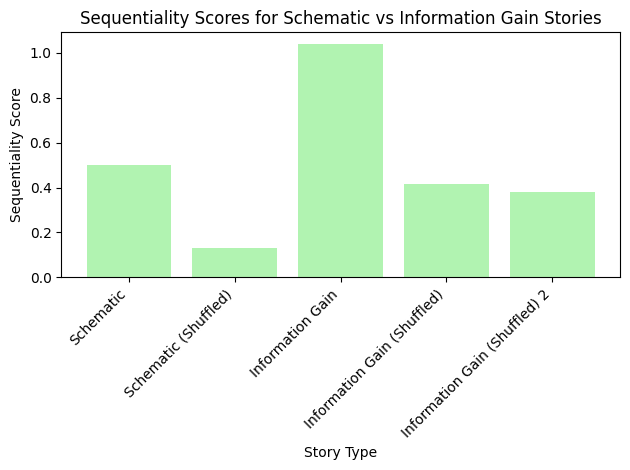

In [36]:
schematic = "Once upon a time, there was a princess trapped in a castle in a far away land. Only a hero of pure heart could rescue her. Luckily, in the Mushroom Kingdom, there was just such a hero. He was brave and noble and would stop at nothing to save the princess. He journeyed far to reach the castle, narrowly escaping death many times. Alas, after all of his hard work he saved the princess, and they lived happily ever after."
schematic_shuffle = "He was brave and noble and would stop at nothing to save the princess. Only a hero of pure heart could rescue her. He journeyed far to reach the castle, narrowly escaping death many times. Once upon a time, there was a princess trapped in a castle in a far away land. Alas, after all of his hard work he saved the princess, and they lived happily ever after. Luckily, in the Mushroom Kingdom, there was just such a hero."
information_gain = "Tom is traveling to a castle. He is traveling there to free a princess. The princess is trapped because she is cursed. The curse will kill her by midnight. It is 10 so Tom must hurry. Tom can break the curse by kissing the princess. He needs to fight monsters before getting there so this will take time. He beats all the monsters and reaches the castle at 11:59. He kisses her and she is saved."
information_gain_shuffle = "He kisses her and she is saved. It is 10 so Tom must hurry. The curse will kill her by midnight. He beats all the monsters and reaches the castle at 11:59. He needs to fight monsters before getting there so this will take time. He is traveling there to free a princess. Tom can break the curse by kissing the princess. Tom is traveling to a castle. The princess is trapped because she is cursed."
information_gain_shuffle2 = "He kisses her and she is saved. It is 10 so Tom must hurry. The curse will kill her by midnight. He is traveling there to free a princess. He beats all the monsters and reaches the castle at 11:59. He needs to fight monsters before getting there so this will take time. Tom can break the curse by kissing the princess. Tom is traveling to a castle. The princess is trapped because she is cursed."

plt.bar(
    ['Schematic', 'Schematic (Shuffled)', 'Information Gain', 'Information Gain (Shuffled)', 'Information Gain (Shuffled) 2'],
    [model.calculate_text_sequentiality(schematic, topic='a fairy tale about a hero rescuing a princess')[0],
     model.calculate_text_sequentiality(schematic_shuffle, topic='a fairy tale about a hero rescuing a princess')[0],
     model.calculate_text_sequentiality(information_gain, topic='a fairy tale about a hero rescuing a princess')[0],
     model.calculate_text_sequentiality(information_gain_shuffle, topic='a fairy tale about a hero rescuing a princess')[0],
     model.calculate_text_sequentiality(information_gain_shuffle2, topic='a fairy tale about a hero rescuing a princess')[0]],
    color='lightgreen',
    alpha=0.7
)

plt.ylabel('Sequentiality Score')
plt.xlabel('Story Type')
plt.title('Sequentiality Scores for Schematic vs Information Gain Stories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()